# Segmentation CNN

Here we are training a CNN to recognize if a letter is in the center of a 32x32 image. This will be used to locate letters in multi char CAPTCHAs

We have a dataset of 32x32 captcha images with one char, labeled if the char is in the middle or not. 

x : (468,000, 32, 32, 3)
y : (468,000, )  0 for uncentered, 1 otherwise

First we will preprocess the data. Our images are black and white, so we will colapse down to 1 color chanel. We will also normalize, shuffle, and make trainging splits

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Automatically reload your external source code
%load_ext autoreload
%autoreload 2

In [15]:
x = np.load('data/x_single.npy')
y = np.load('data/y_single_pos.npy')

print(f"x shape: {x.shape}")
print(f'y shape: {y.shape}')

x shape: (468000, 32, 32, 3)
y shape: (468000,)


In [16]:
#Converting to greyscale
x = np.mean(x, axis=3)
print(x.shape)

(468000, 32, 32)


In [17]:
#Normalizing
x /= 256
print(f"max x : {np.max(x)}")
print(f"min y : {np.min(x)}")

max x : 0.99609375
min y : 0.0


In [18]:
#Shuffling
print("These should be different")
print(x[0,0,:])
idx = np.arange(x.shape[0])
np.random.shuffle(idx)
x = x[idx, :, :]
y = y[idx]
print(x[0,0,:])
print(x.shape)
print(y.shape)



These should be different
[0.9140625  0.91796875 0.9140625  0.9140625  0.91796875 0.921875
 0.91796875 0.89453125 0.8359375  0.85546875 0.90625    0.9375
 0.953125   0.953125   0.95703125 0.9609375  0.96875    0.953125
 0.9375     0.94921875 0.90234375 0.78125    0.87890625 0.94140625
 0.875      0.87109375 0.890625   0.8671875  0.8828125  0.9375
 0.86328125 0.80078125]
[0.77734375 0.71484375 0.65625    0.69921875 0.75390625 0.8125
 0.88671875 0.7890625  0.625      0.63671875 0.6328125  0.6171875
 0.66015625 0.71875    0.7890625  0.82421875 0.8125     0.74609375
 0.74609375 0.7890625  0.87890625 0.8828125  0.84375    0.74609375
 0.83984375 0.86328125 0.72265625 0.703125   0.6484375  0.47265625
 0.58984375 0.734375  ]
(468000, 32, 32)
(468000,)


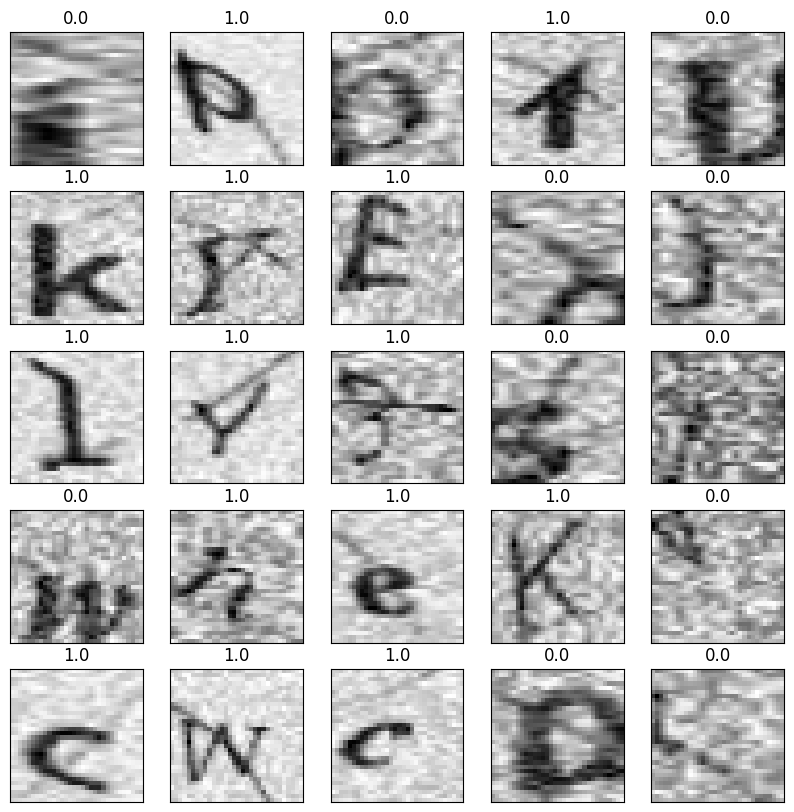

In [19]:
fig, axs = plt.subplots(5,5)
N = x.shape[0]
fig.set_size_inches(10,10)
for i in range(5):
    for j in range(5):
        ax = axs[i,j]
        idx = np.random.randint(N)
        ax.imshow((x[idx,:,:]), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(y[idx])
plt.show()

In [20]:
x = np.squeeze(x)
print(x.shape)

(468000, 32, 32)


In [21]:
#We need to have a singlton dim for chans dimention
if(len(x.shape) == 3):
    x = x[:, :, :, None]
print(x.shape)
np.save('data/x_single_preprocessed.npy', x)
np.save('data/y_single_pos_preprocessed.npy', y)
print("Preprocessed data saved to disk")

(468000, 32, 32, 1)
Preprocessed data saved to disk


In [2]:
#Splitting the data in to test and training sets. Going with a 80/20 
#Also getting dev sets for debugging and tuning hyper parameters.

x = np.load('data/x_single_preprocessed.npy')
y = np.load('data/y_single_pos_preprocessed.npy')

N = x.shape[0]

split_idx = int(N * 0.8)
test_split = 3000
x_train = x[:split_idx,:, :, :] 
x_val = x[split_idx:-test_split, :, :, :]
x_test = x[-test_split:, :, :, :]
x_train_dev = x[:3000, :, :, :]
x_val_dev = x[split_idx:split_idx+500, :, :, :]

y_train = y[:split_idx] 
y_val = y[split_idx:-test_split]
y_test = y[-test_split:]
y_train_dev = y[:3000]
y_val_dev = y[split_idx:split_idx+500]

dataset = (x_train, x_val, x_test, x_train_dev, x_val_dev, y_train, y_val, y_test, y_train_dev, y_val_dev)

for datum in dataset:
    print(datum.shape)


(374400, 32, 32, 1)
(90600, 32, 32, 1)
(3000, 32, 32, 1)
(3000, 32, 32, 1)
(500, 32, 32, 1)
(374400,)
(90600,)
(3000,)
(3000,)
(500,)


# CNN Training

Using tensor flow model here. Following this tutorial:https://www.tensorflow.org/tutorials/images/cnn

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models

2023-04-13 18:16:45.177322: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 18:16:45.422507: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-13 18:16:45.422525: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-13 18:16:46.433747: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [4]:
segnet = models.Sequential()
#CNN layer
segnet.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,1)))
segnet.add(layers.MaxPooling2D((2, 2)))
segnet.add(layers.Conv2D(64, (3, 3), activation='relu'))
segnet.add(layers.MaxPooling2D((2, 2)))
segnet.add(layers.Conv2D(64, (3, 3), activation='relu'))

#Dense Layer
segnet.add(layers.Flatten())
segnet.add(layers.Dense(64, activation='relu'))
segnet.add(layers.Dense(1))

segnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

2023-04-13 18:16:50.647473: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-13 18:16:50.647739: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-13 18:16:50.647762: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (MrKrabs): /proc/driver/nvidia/version does not exist
2023-04-13 18:16:50.648921: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
#Training Network
segnet.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = segnet.fit(x_train_dev, y_train_dev, epochs=10, 
                    validation_data=(x_val_dev, y_val_dev))


Epoch 1/10
94/94 [==============================] - 2s 15ms/step - loss: 0.4975 - accuracy: 0.6997 - val_loss: 0.2982 - val_accuracy: 0.8360
Epoch 2/10
94/94 [==============================] - 1s 13ms/step - loss: 0.2317 - accuracy: 0.9060 - val_loss: 0.2916 - val_accuracy: 0.8340
Epoch 3/10
94/94 [==============================] - 1s 11ms/step - loss: 0.1538 - accuracy: 0.9387 - val_loss: 0.1713 - val_accuracy: 0.9260
Epoch 4/10
94/94 [==============================] - 1s 12ms/step - loss: 0.1220 - accuracy: 0.9540 - val_loss: 0.1211 - val_accuracy: 0.9420
Epoch 5/10
94/94 [==============================] - 1s 11ms/step - loss: 0.0856 - accuracy: 0.9657 - val_loss: 0.0953 - val_accuracy: 0.9520
Epoch 6/10
94/94 [==============================] - 1s 12ms/step - loss: 0.0999 - accuracy: 0.9607 - val_loss: 0.1126 - val_accuracy: 0.9600
Epoch 7/10
94/94 [==============================] - 1s 11ms/step - loss: 0.0866 - accuracy: 0.9643 - val_loss: 0.0937 - val_accuracy: 0.9600
Epoch 8/10
94

94/94 - 0s - loss: 0.0591 - accuracy: 0.9810 - 333ms/epoch - 4ms/step


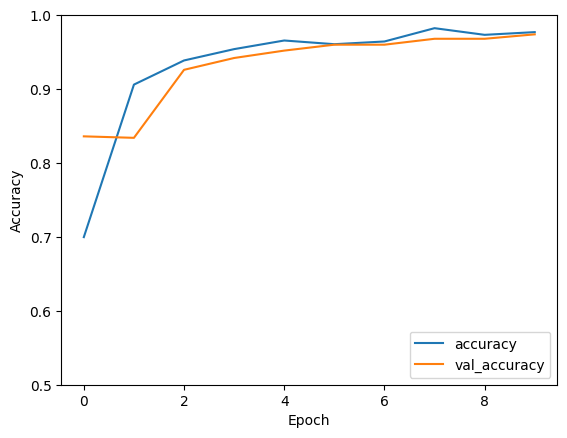

In [6]:
#Plotting Training Data
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
#Printing the test set accuracy
test_loss, test_acc = segnet.evaluate(x_test,  y_test, verbose=2)


In [20]:
#Testing on full size images
#Loading in with imgage_preprocess.py
import image_preprocess
import os

if not os.path.exists("data/x_multi_preprocessed.npy") and not os.path.exists("data/y_multi_preprocessed.npy"):
    print("Preprocessing data...")
    x_multi, y_multi = image_preprocess.preprocess_image_data("data/x_multi.npy", "data/y_multi.npy")
    print("Preprocessed data saved to disk")
else:
    x_multi = np.load("data/x_multi_preprocessed.npy")
    y_multi = np.load("data/y_multi_preprocessed.npy")

print(f"Loaded in images, x.shape = {x_multi.shape}")

Loaded in images, x.shape = (23400, 72, 200, 1)


In [21]:
#Getting test data
x_multi = x_multi[:1000, :, :]
y_multi = y_multi[:1000]
print(x_multi.shape)
print(y_multi.shape)

(1000, 72, 200, 1)
(1000,)


In [19]:
%reset array

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [23]:
#Setting up filter function (Taken from CNN Project)
def conv2_gray(img, model, frame=(32,32), verbose=False):
    img_y, img_x, n_chan = img.shape
    ker_x, ker_y = frame

    if verbose:
        print(f'img_x={img_y}, img_y={img_x}')
        print(f'ker_x={ker_x}, ker_y={ker_y}')

    if ker_x != ker_y:
        print('Kernels must be square!')
        return

#     #Padding image with zeros
    padding = int(np.ceil((ker_x - 1)/2))
#     img_padded = np.zeros((img_y+(2*padding), img_x+(2*padding), n_chan))
#     img_padded[padding:-padding, padding:-padding, :] = img
#     img_padded_y, img_padded_x, _ = img_padded.shape

#     if verbose:
#         print(f"Padded Image Size: {img_padded.shape}")
    #Output array
    filteredImg = np.zeros(img.shape)

    for i in range(padding, img_y-padding):
        for j in range(padding, img_x-padding):
            correction = 0 if ker_x%2 == 0 else 1
            selection = img[None, i-padding:i+padding+correction, j-padding:j+padding+correction, :]
            if verbose and i==padding and j==padding:
                print(f"Frame size: {selection.shape}")
            filteredImg[i-padding, j-padding, :] = model.predict(selection)

    return filteredImg

test = conv2_gray(x_multi[0], segnet, verbose=True)

img_x=72, img_y=200
ker_x=32, ker_y=32
Frame size: (1, 32, 32, 1)
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step


In [25]:
print(test.size)
plt.imshow(test)